In [1]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/522'

role = sagemaker.get_execution_role()

In [2]:
!pip install nilearn
!pip install torch
!pip install torchvision
!pip install tqdm

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 752.0MB 60kB/s  eta 0:00:01    18% |██████                          | 141.6MB 54.5MB/s eta 0:00:12    40% |█████████████                   | 305.5MB 67.1MB/s eta 0:00:07    95% |██████████████████████████████▍ | 715.0MB 63.2MB/s eta 0:00:01    99% |███████████████████████████████▉| 749.0MB 61.0MB/s eta 0:00:01
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/c9/40/058b12e8ba10e35f89c9b1fdfc2d4c7f8c05947df2d5eb3c7b258019fda0/tqdm-4.46.0-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 20.1 is

In [3]:
import numpy as np
import tqdm
import os
import nibabel as nib
import pandas as pd
import nilearn
import os
import datetime
import torch
import random
from skimage import exposure
from matplotlib import pyplot as plt
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# !unzip native_2.zip
# !unzip native_1.zip

In [5]:
nib_images = []
nib_lesions = []

In [6]:
for subdir in os.listdir('native_1'):
    if subdir != '.DS_Store':
        look = 'native_1' + '/' + subdir
        for subsubdir in os.listdir(look):
            if subsubdir != '.DS_Store':
                sublook = look + '/' + subsubdir
                nib_images.append(nib.load(sublook + '/' + subsubdir +'.nii.gz'))
                nib_lesions.append(nib.load(sublook + '/' + subsubdir + '_LesionSmooth.nii.gz'))

In [7]:
for subdir in os.listdir('native_2'):
    if subdir != '.DS_Store':
        look = 'native_2' + '/' + subdir
        for subsubdir in os.listdir(look):
            if subsubdir != '.DS_Store':
                sublook = look + '/' + subsubdir
                nib_images.append(nib.load(sublook + '/' + subsubdir +'.nii.gz'))
                nib_lesions.append(nib.load(sublook + '/' + subsubdir + '_LesionSmooth.nii.gz'))

In [9]:
d = [48, 56, 62, 64]

In [12]:
metadata = pd.read_csv('metadata.csv')

In [19]:
def get_3d_features_train(brain, lesion):
    s0, s1, s2 = brain.shape
    ran = 0.01
    features = []
    labels = []
    for k in range(s2 - 100):
        for i in range(s0 - 100):
            for j in range(s1 - 100):
                if lesion[i+50, j+50, k+50] != 0 or random.random() < ran:
                    indices = list(np.arange(j+38,j+63)) + list(np.arange(s1-1-(j+63),s1-1-(j+38)))
                    features.append(brain[i+38:i+63, indices, k+38:k+63])
                    labels.append(lesion[i+50, j+50, k+50])
    return features, labels

In [77]:
def get_3d_features_test(brain, lesion, val):
    s0, s1, s2 = brain.shape
    ran = 0.0001
    ran2 = 0.2
    features = []
    labels = []
    for k in range(s2 - 100):
        for i in range(s0 - 100):
            for j in range(s1 - 100):
                l = lesion[i+50, j+50, k+50]
                if (random.random() < ran and l==0) or (random.random() < ran2 and l==1):
                    indices = list(np.arange(j+38,j+63)) + list(np.arange(s1-1-(j+63),s1-1-(j+38)))
                    features.append(brain[i+38:i+63, indices, k+38:k+63])
                    labels.append(lesion[i+50, j+50, k+50])
    return features, labels

In [17]:
brain_data = []
lesion_data = []

for i in tqdm.tqdm(range(100)): 
    if i not in d and i not in [36,37]: # where brain sizes and lesion sizes are different
        img, lesion = nib_images[i], nib_lesions[i]
        # normalize
        brain = img.get_fdata()/255
        lesion = lesion.get_fdata()/255
        #reshape for consistency
        if i < 31:
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        elif i > 85:
          brain = np.swapaxes(brain,1,2).copy()
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.swapaxes(lesion,1,2).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        #histogram equalize
        brain = exposure.equalize_hist(brain)
        if brain.shape[0:3] < (50, 50, 50):
            continue
        features, labels = get_3d_features_train(brain, lesion)
        brain_data.extend(features)
        lesion_data.extend(labels)


100%|██████████| 100/100 [07:59<00:00,  4.79s/it]


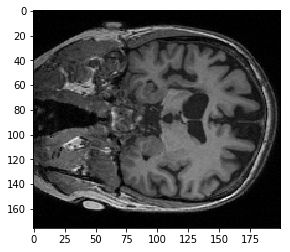

In [18]:
img1 = nib_images[227].get_fdata()/255
plt.imshow(img1[:,100,:], cmap='gray')

In [78]:
brain_data_valid = []
lesion_data_valid = []
indexes = []

for i in tqdm.tqdm(range(100,125)): 
    if i not in d: # where brain sizes and lesion sizes are different
#         print(i)
        # img, lesion = preprocess(nib_images[0], nib_lesions[0])
        img, lesion = nib_images[i], nib_lesions[i]
        # normalize
        brain = img.get_fdata()/255
        lesion = lesion.get_fdata()/255
        #reshape for consistency
        if i < 31:
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        elif i > 85:
          brain = np.swapaxes(brain,1,2).copy()
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.swapaxes(lesion,1,2).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        #histogram equalize
        brain = exposure.equalize_hist(brain)
        # padding
        # padded_brain, padded_lesion = padding(brain, lesion)

        # get features
        if brain.shape[0:3] < (50, 50, 50):
            continue
        features, labels = get_3d_features_test(brain, lesion, True)
        length = len(features)
        indexes.extend([i]*length)
        
        brain_data_valid.extend(features)
        lesion_data_valid.extend(labels)

100%|██████████| 25/25 [01:08<00:00,  2.74s/it]


In [137]:
brain_data_test = []
lesion_data_test = []

for i in tqdm.tqdm(range(125,150)): 
    if i not in d: # where brain sizes and lesion sizes are different
        # img, lesion = preprocess(nib_images[0], nib_lesions[0])
        img, lesion = nib_images[i], nib_lesions[i]
        # normalize
        brain = img.get_fdata()/255
        lesion = lesion.get_fdata()/255
        #reshape for consistency
        if i < 31:
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        elif i > 85:
          brain = np.swapaxes(brain,1,2).copy()
          brain = np.rot90(brain,1,axes=(0,2)).copy()
          lesion = np.swapaxes(lesion,1,2).copy()
          lesion = np.rot90(lesion,1,axes=(0,2)).copy()
        #histogram equalize
        brain = exposure.equalize_hist(brain)

        # get features
        if brain.shape[0:3] < (50, 50, 50):
            continue
        features, labels = get_3d_features_test(brain, lesion, False)
        brain_data_test.extend(features)
        lesion_data_test.extend(labels)

100%|██████████| 25/25 [01:25<00:00,  3.40s/it]


In [23]:
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

In [29]:
class BrainsDataset3D(Dataset):
    def __init__(self, brains, lesions, transform=None):
        self.brains = brains
        self.lesions = lesions
        self.transform = transform

    def __len__(self):
        return len(self.brains)

    def __getitem__(self, idx):
        brains = self.brains[idx].reshape(1, 25, 50, 25)
        sample = {'brain': brains, 'lesion': self.lesions[idx]}
        if self.transform:
            sample['brain'] = self.transform(sample['brain'][0]).unsqueeze(0)
        return sample

In [82]:
brains_dataset = BrainsDataset3D(brain_data, lesion_data, transform=transforms.ToTensor())
brains_valid = BrainsDataset3D(brain_data_valid, lesion_data_valid, transform=transforms.ToTensor())
brains_test = BrainsDataset3D(brain_data_test, lesion_data_test, transform=transforms.ToTensor())
dataloader = DataLoader(brains_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(brains_valid, batch_size = 256, shuffle=False)
test_dataloader = DataLoader(brains_test, batch_size = 2000, shuffle=False)

In [84]:
def dice(true, pred):
  true = np.array(true)
  pred = np.array(pred)
  intersection = np.sum(true*pred)
  union = np.sum(true == 1) + np.sum(pred == 1)
  print(intersection)
  return 2*intersection/union

In [36]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv = nn.Sequential(nn.Conv3d(1,8,3,1,1),
                                 nn.MaxPool3d(2),
                                 nn.ReLU(),
                                 nn.Conv3d(8,16,3,1,1),
                                 nn.MaxPool3d(2),
                                 nn.ReLU(),
                                 nn.Conv3d(16,32,3,1,1),
                                 nn.MaxPool3d(2),
                                 nn.ReLU(),
                                 nn.Conv3d(32,16,3,1,1),
                                 nn.ReLU(),
                                 nn.Conv3d(16,8,3,1,1),
                                 nn.ReLU())
        self.lin = nn.Sequential(nn.Linear(432,64),
                                nn.ReLU(),
                                nn.Linear(64,2),
                                nn.Softmax(0))
        
    def forward(self,brain):
        out = self.conv(brain)
        out = out.view(out.shape[0],-1)
        out = self.lin(out)
        
        return out

In [62]:
def train_model(train_dataloader, optimizer, loss, net,test_dataloader):
  # TODO: Insert your code here
  net = net.to(device)
  true = np.array([])
  output_list = np.array([])
  interval_losses = []
  losses = []
  for epoch in range(1):
    interval_loss = 0
    print(datetime.datetime.now())
    total_loss = 0
    total = 0
    correct = 0
    epoch_iterator = tqdm.tqdm(train_dataloader)
    net.train()
    
    for num, data in enumerate(epoch_iterator):
      inputs, labels = data['brain'], data['lesion']
      inputs, labels = inputs.float().to(device), labels.float().to(device)

      optimizer.zero_grad()
      outputs = net(inputs)
      pred = torch.max(outputs, 1)[1]
      output_list = np.append(output_list, pred.cpu().numpy())
      true = np.append(true, labels.cpu().numpy())

      loss_value = loss(outputs, labels.long())*10
      if num%100 == 0 and num!= 0:
        interval_losses.append(interval_loss/100)
        interval_loss = 0

      loss_value.backward()
      optimizer.step()
      
      interval_loss += loss_value.item()
      total_loss += loss_value.item()
    
      total += len(labels)
    
    losses.append(total_loss/total)
    print(f"Epoch: {epoch}, Loss: {total_loss/total}, Train Dice: {dice(output_list,true)}, Valid Dice: {test_model(test_dataloader, net)[0]}")
    print()
    
  return losses,output_list,true, interval_losses

In [76]:
def test_model(test_dataloader, net):
  # TODO: Insert your code here
  correct = 0
  total = 0
  output_list = np.array([])
  true = np.array([])
  with torch.no_grad():
    for data in tqdm.tqdm(test_dataloader):
      inputs, labels = data['brain'], data['lesion']
      inputs, labels = inputs.float().to(device), labels.float().to(device)
      
      outputs = net(inputs)
      pred = torch.max(outputs, 1)[1]
      output_list = np.append(output_list, pred.cpu().numpy())
      
      true = np.append(true, labels.cpu().numpy())
      total += 1
      
  print(np.count_nonzero(output_list))
  print(np.count_nonzero(true))
  return dice(output_list,true), output_list, true


In [139]:
cnn = CNN()
optimizer = optim.Adam(cnn.parameters(),lr=0.00001)
loss_function = nn.CrossEntropyLoss()
cnn = torch.nn.DataParallel(cnn)

losses,pred,true, int_losses = train_model(dataloader, optimizer, loss_function, cnn, val_dataloader)

  0%|          | 0/24619 [00:00<?, ?it/s]

2020-05-07 22:06:40.579392


  0%|          | 0/147 [00:00<?, ?it/s]

491404.00784361083


100%|██████████| 147/147 [11:44<00:00,  4.79s/it]  

13360 
 7537 
 3840.0 
 Epoch: 0, Loss: 0.09652629042730622, Train Dice: 0.7077220979794091, Valid Dice: 0.46751686845001674


Text(0, 0.5, 'Loss')

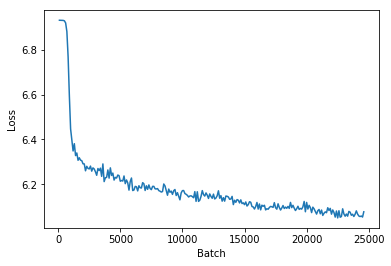

In [131]:
plt.plot(np.arange(100,24620,100), int_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')

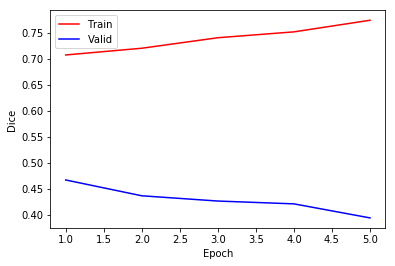

In [135]:
plt.plot(range(1,6), train_dices, color='red')
plt.plot(range(1,6), valid_dices, color='blue')
plt.legend(['Train', 'Valid'])
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.show()

In [85]:
dice_score, pred, true = test_model(test_dataloader,cnn)

100%|██████████| 90/90 [00:06<00:00, 14.66it/s]

8853
7946
4191.0


In [86]:
print(f"Final Test Result: {dice_score}")

Final Test Result: 0.49895827132567416


In [99]:
combined = np.array(list(zip(indices,pred,true)))

In [100]:
indices = np.array(indexes)
side_analysis = pd.DataFrame(combined, columns=['indices','pred','true'])

In [107]:
side_analysis['Side'] = side_analysis['indices'].apply(lambda x: metadata.iloc[int(x)]['Primary Stroke Location Hemisphere'])

In [109]:
side_analysis['Correct'] = side_analysis.pred == side_analysis.true

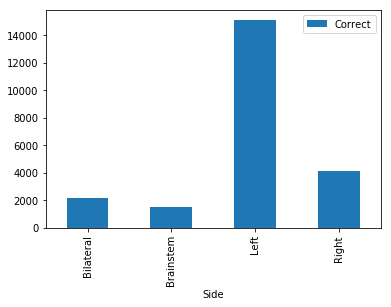

In [125]:
side_analysis[['Side','Correct']].groupby(['Side']).count().plot(kind='bar')